In [17]:
import os
import json
from PIL import Image

import torch
from transformers import CLIPProcessor, CLIPModel

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

RANDOM_STATE = 0


def predict(path2image, labels, processor, model, device):
    image = Image.open(path2image)
    with torch.no_grad():
        
        inputs = processor(
            text=labels, images=image, return_tensors="pt", padding=True
        ).to(device)
        
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image # this is the image-text similarity score
        probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
        return labels[probs.argmax()]

What we've learned so far:
- writing system is the golden feature
- people in Hong Kong and Taiwan speak Chinese variants

# Data

In [2]:
with open("../data/href2details.json", encoding="utf-8") as f:
    href2details = json.load(f)
with open("../data/num2details.json", encoding="utf-8") as f:
    num2details = json.load(f)

In [3]:
data = pd.DataFrame()

In [4]:
root = "../data/posters"
EXT = ".jpg"

data["rel_path"] = [f"{root}/{fname}" for fname in os.listdir(root) if fname.endswith(EXT)]

data["filename"] = data["rel_path"].apply(os.path.basename)
data["href"] = data.filename.apply(
    lambda x: x.split("_")[0]
)
data["Country"] = data["href"].apply(
    lambda x: href2details[f"/{x}"]["Country:"][len("Country:"):].strip()
)

In [5]:
data = data[data["Country"].apply(lambda x: x not in {'Hong Kong', 'Taiwan'})]

In [9]:
data["Country"].value_counts()

South Korea    5825
Japan          5590
China          4061
Thailand       1744
Philippines     460
Name: Country, dtype: int64

In [37]:
sample = data.groupby("Country", group_keys=False).apply(
    lambda x: x.sample(
        data["Country"].value_counts().to_list()[-1]
        , random_state=RANDOM_STATE
    )
)

sample.head(1)

,rel_path,filename,href,Country
5555,../data/posters/27370-transmission_JxZqXc.jpg,27370-transmission_JxZqXc.jpg,27370-transmission,China


In [42]:
tmp = data.drop(sample.index)
tmp = tmp.assign(
    pred=tmp["rel_path"].progress_apply(
        lambda x: predict(x, labels, processor, model, device)
    )
)

  0%|          | 0/15380 [00:00<?, ?it/s]

China	-> South Korea	../data/posters/10127-wedding-bible_NPEKec.jpg


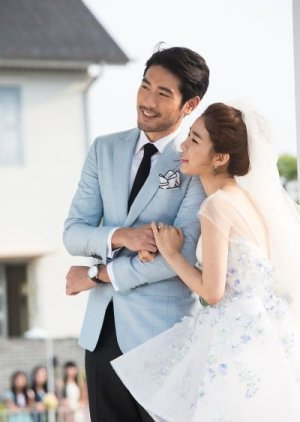

In [67]:
for t in tmp[
    tmp["Country"].apply(lambda x: x in {'China', 'South Korea'})
    & tmp["pred"].apply(lambda x: x in {'China', 'South Korea'})
    & (tmp["Country"] != tmp["pred"])
].itertuples():
    print (f"{t.Country}\t-> {t.pred}", t.rel_path, sep="\t")
    display(Image.open(t.rel_path))
    break

In [28]:
sample.reset_index(drop=True, inplace=True)
sample.head(1)

,rel_path,filename,href,Country
0,../data/posters/27370-transmission_JxZqXc.jpg,27370-transmission_JxZqXc.jpg,27370-transmission,China


In [11]:
sample.shape, sample["Country"].value_counts()

((2300, 4),
 China          460
 Japan          460
 Philippines    460
 South Korea    460
 Thailand       460
 Name: Country, dtype: int64)

# Zero-shot

In [12]:
# labels = ['China', 'Hong Kong', 'Japan', 'Philippines', 'South Korea', 'Taiwan', 'Thailand']
labels = sorted(data["Country"].unique())
labels

['China', 'Japan', 'Philippines', 'South Korea', 'Thailand']

In [13]:
model_id = "openai/clip-vit-base-patch32"
cache_dir = "../models/"

model = CLIPModel.from_pretrained(model_id, cache_dir=cache_dir)
processor = CLIPProcessor.from_pretrained(model_id, cache_dir=cache_dir)

In [14]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    model.to(device)
model.device

device(type='cuda', index=0)

In [20]:
X = sample["rel_path"]
y = sample["Country"]

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
# skf.get_n_splits(X, y)

In [22]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    
    fold_test = sample.loc[test_index]
    
    fold_test["pred"] = fold_test["rel_path"].progress_apply(
        lambda x: predict(x, labels, processor, model, device)
    )
    
    print(classification_report(fold_test["Country"], fold_test["pred"]))
    
    print(confusion_matrix(fold_test["Country"], fold_test["pred"]))

  0%|          | 0/767 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       China       0.73      0.64      0.69       154
       Japan       0.73      0.86      0.79       153
 Philippines       0.86      0.74      0.80       153
 South Korea       0.60      0.91      0.73       154
    Thailand       0.94      0.54      0.69       153

    accuracy                           0.74       767
   macro avg       0.77      0.74      0.74       767
weighted avg       0.77      0.74      0.74       767

[[ 99  18   0  37   0]
 [ 10 132   0  11   0]
 [ 12  13 113  10   5]
 [  6   8   0 140   0]
 [  8  10  18  34  83]]


  0%|          | 0/767 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       China       0.70      0.67      0.68       153
       Japan       0.75      0.84      0.80       154
 Philippines       0.88      0.70      0.78       153
 South Korea       0.58      0.89      0.70       153
    Thailand       0.86      0.52      0.65       154

    accuracy                           0.72       767
   macro avg       0.75      0.72      0.72       767
weighted avg       0.75      0.72      0.72       767

[[102  18   1  31   1]
 [  9 130   0  14   1]
 [ 17   7 107  12  10]
 [  4   9   3 136   1]
 [ 13   9  11  41  80]]


  0%|          | 0/766 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       China       0.66      0.64      0.65       153
       Japan       0.77      0.87      0.82       153
 Philippines       0.91      0.69      0.79       154
 South Korea       0.60      0.91      0.72       153
    Thailand       0.91      0.58      0.70       153

    accuracy                           0.74       766
   macro avg       0.77      0.74      0.74       766
weighted avg       0.77      0.74      0.74       766

[[ 98  18   0  37   0]
 [ 10 133   1   9   0]
 [ 20   6 107  13   8]
 [  4   9   0 139   1]
 [ 16   6  10  33  88]]


In [25]:
print(labels)

['China', 'Japan', 'Philippines', 'South Korea', 'Thailand']


In [128]:
# posterpath = "../data/posters/not_released_yet/27319-the-golden-hairpin_k644m_4c.jpg"
posterpath = "../data/posters/714369-pepero-was-taken-away-on-pepero-day_e4J7K_4c.jpg"
posterpath = "../data/posters/711027-enhypen-en-log_BLYz5_4c.jpg"
posterpath = "../data/posters/693057-siwon-s-fortune-cookie_XND8q_4c.jpg"
posterpath = "../data/posters/77567-fight-for-love_k36Nw_4c.jpg" # China
posterpath = "../data/posters/680631-ka-sunscreen_Rg3oo_4c.jpg" # Thailand
posterpath = "../data/posters/79321-the-serpents-song_BNXKb_4c.jpg" # Thailand
image = Image.open(posterpath)
# display(image)

In [ ]:
with torch.no_grad():
    
    inputs = processor(text=labels, images=image, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

In [88]:
sorted(zip(probs.flatten(), labels), reverse=True)

[(tensor(0.4053), 'South Korea'),
 (tensor(0.2192), 'Japan'),
 (tensor(0.1207), 'China'),
 (tensor(0.1014), 'Hong Kong'),
 (tensor(0.0665), 'Thailand'),
 (tensor(0.0563), 'Philippines'),
 (tensor(0.0305), 'Taiwan')]

In [42]:
data[data["Country"] == "Hong Kong"]["rel_path"]

63       ../data/posters/10114-love-actually...-sucks_R...
64                 ../data/posters/10115-voyage_jQee8c.jpg
237       ../data/posters/10491-for-love-we-can_JBAvYc.jpg
269      ../data/posters/10554-the-accidental-spy_E5bgl...
270      ../data/posters/10555-naked-ambition-2_lBvqEc.jpg
                               ...                        
18878            ../data/posters/9655-butterfly_BdDZAc.jpg
18888    ../data/posters/9684-rise-of-the-legend_JZnzJc...
18898          ../data/posters/9710-line-walker_RjJxEc.jpg
18938               ../data/posters/983-d.i.e_x8A3z_4c.jpg
19032              ../data/posters/998-so-close_Q2dk6c.jpg
Name: rel_path, Length: 678, dtype: object

# Not released yet

In [4]:
for k, v in num2details.items():
    href2details[f"/{k}"] = v

In [5]:
len(href2details)

31454

In [3]:
data = pd.DataFrame()

In [7]:
root = "../data/posters/not_released_yet"
EXT = ".jpg"

data["rel_path"] = [f"{root}/{fname}" for fname in os.listdir(root) if fname.endswith(EXT)]

data["filename"] = data["rel_path"].apply(os.path.basename)
data["href"] = data.filename.apply(
    lambda x: x.split("_")[0]
)



data["Country"] = data["href"].apply(
    lambda x: href2details[f"/{x}"]["Country:"][len("Country:"):].strip()
)

In [8]:
data["Country"].value_counts()

South Korea    250
China           36
Thailand        34
Japan           24
Taiwan           4
Hong Kong        2
Name: Country, dtype: int64

In [11]:
data["Country"].value_counts()

South Korea    280
China           41
Thailand        35
Japan           31
Hong Kong        4
Taiwan           4
Name: Country, dtype: int64

In [14]:
data = data[data["Country"].apply(lambda x: x not in {'Hong Kong', 'Taiwan'})]

In [15]:
data["Country"].value_counts()

South Korea    280
China           41
Thailand        35
Japan           31
Name: Country, dtype: int64

In [16]:
sample = data.groupby("Country", group_keys=False).apply(
    lambda x: x.sample(
        data["Country"].value_counts().to_list()[-1]
        , random_state=RANDOM_STATE
    )
).reset_index(drop=True)

sample.head(1)

,rel_path,filename,href,Country
0,../data/posters/not_released_yet/737225-jie-zi...,737225-jie-zi-gui-cheng_r4qqZ_4c.jpg,737225-jie-zi-gui-cheng,China


In [17]:
sample.shape, sample["Country"].value_counts()

((124, 4),
 China          31
 Japan          31
 South Korea    31
 Thailand       31
 Name: Country, dtype: int64)

In [19]:
labels = sorted(data["Country"].unique())
labels

['China', 'Japan', 'South Korea', 'Thailand']

In [26]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    
    fold_test = sample.loc[test_index]
    
    fold_test["pred"] = fold_test["rel_path"].progress_apply(
        lambda x: predict(x, labels, processor, model, device)
    )
    
    print(classification_report(fold_test["Country"], fold_test["pred"]))

  0%|          | 0/42 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       China       0.92      1.00      0.96        11
       Japan       1.00      0.90      0.95        10
 South Korea       1.00      1.00      1.00        10
    Thailand       1.00      1.00      1.00        11

    accuracy                           0.98        42
   macro avg       0.98      0.97      0.98        42
weighted avg       0.98      0.98      0.98        42



  0%|          | 0/41 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       China       0.83      1.00      0.91        10
       Japan       0.77      0.91      0.83        11
 South Korea       1.00      0.90      0.95        10
    Thailand       1.00      0.70      0.82        10

    accuracy                           0.88        41
   macro avg       0.90      0.88      0.88        41
weighted avg       0.90      0.88      0.88        41



  0%|          | 0/41 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       China       0.71      1.00      0.83        10
       Japan       1.00      0.80      0.89        10
 South Korea       0.77      0.91      0.83        11
    Thailand       1.00      0.60      0.75        10

    accuracy                           0.83        41
   macro avg       0.87      0.83      0.83        41
weighted avg       0.87      0.83      0.83        41



In [29]:
print(labels)
confusion_matrix(fold_test["Country"], fold_test["pred"])

['China', 'Japan', 'South Korea', 'Thailand']


array([[10,  0,  0,  0],
       [ 2,  8,  0,  0],
       [ 1,  0, 10,  0],
       [ 1,  0,  3,  6]], dtype=int64)